<a href="https://colab.research.google.com/github/jonkrohn/DLTFpT/blob/master/notebooks/dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Activity Classifier

In this notebook, we build a dense neural net to classify PE activity. We use demographic data as well as the ecceleration data

#### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate , Input
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.metrics import confusion_matrix
import os 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tensorflow.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11646796726518184603
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6826252619393838332
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4022219571
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3282568478252106823
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11751506977302787113
physical_device_desc: "device: XLA_GPU device"
]
# GPUs Available:  1


'2.3.1'

#### Set hyperparameters

In [4]:
# output directory name:
output_dir = 'model_output/demographic-cnn'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency




# convolutional layer architecture:
n_conv = 64
k_conv = 3 

# dense layer architecture: 
n_dense = 256
dropout = 0.2

# training:
epochs = 30
batch_size = 128


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [5]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [6]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']
accel_input_shape = list(accel_array.shape)
meta_input_shape = list(meta_array.shape)


#### Preprocess data

### Data preparation 
1- Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>

2- Standardize the demographic data
3- Split and shuffle



In [40]:
lb = LabelBinarizer()
y = lb.fit_transform(labels_array)
n_class = len(lb.classes_)
class_list = lb.classes_

In [15]:
sc = StandardScaler()
meta_array = sc.fit_transform(meta_array)

In [17]:
X_train_index, X_valid_index, y_train, y_valid = train_test_split(
     (np.arange(len(accel_array))), y, test_size=0.1, random_state=65)
X_accel_train = accel_array[X_train_index]
X_accel_valid = accel_array[X_valid_index]
X_meta_train = meta_array[X_train_index]
X_meta_valid = meta_array[X_valid_index]





#### Design neural network architecture using functional API

In [18]:
accel_input = Input(shape=accel_input_shape[1:])
meta_input = Input(shape=meta_input_shape[1:])
x = Conv1D(n_conv, k_conv, activation='relu')(accel_input)
x = GlobalMaxPooling1D()(x)
meta_input_x = Flatten()(meta_input)
x = Concatenate()([x,meta_input_x])
x = Dense(n_dense, activation='relu')(x)
x = Dropout(dropout)(x)
x = Dense(n_dense, activation='relu')(x)
x = Dropout(dropout)(x)
output = Dense(n_class, activation='softmax')(x)
model = Model(inputs=[accel_input, meta_input], outputs=output, name='biInput')
model.summary()

Model: "biInput"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 90, 3)]      0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 88, 64)       640         input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 64)           0           conv1d_2[0][0]                   
____________________________________________________________________________________________

#### Configure model

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [20]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [21]:
model.fit(x=[X_accel_train, X_meta_train], y=y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=([X_accel_valid, X_meta_valid], y_valid), 
         )# callbacks=[modelcheckpoint])


Epoch 1/30
456/456 [==============================] - 2s 5ms/step - loss: 0.9140 - accuracy: 0.6479 - val_loss: 0.7007 - val_accuracy: 0.7386
Epoch 2/30
456/456 [==============================] - 2s 4ms/step - loss: 0.5622 - accuracy: 0.8097 - val_loss: 0.5382 - val_accuracy: 0.8145
Epoch 3/30
456/456 [==============================] - 2s 4ms/step - loss: 0.4531 - accuracy: 0.8525 - val_loss: 0.3549 - val_accuracy: 0.8941
Epoch 4/30
456/456 [==============================] - 2s 4ms/step - loss: 0.3929 - accuracy: 0.8724 - val_loss: 0.3065 - val_accuracy: 0.9060
Epoch 5/30
456/456 [==============================] - 2s 4ms/step - loss: 0.3533 - accuracy: 0.8876 - val_loss: 0.2750 - val_accuracy: 0.9146
Epoch 6/30
456/456 [==============================] - 2s 4ms/step - loss: 0.3251 - accuracy: 0.8985 - val_loss: 0.2624 - val_accuracy: 0.9174
Epoch 7/30
456/456 [==============================] - 2s 4ms/step - loss: 0.3000 - accuracy: 0.9057 - val_loss: 0.2628 - val_accuracy: 0.9154
Epoch 

In [ ]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


#### Evaluate

In [18]:
# model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [23]:
y_hat = model.predict([X_accel_valid, X_meta_valid])

In [24]:
len(y_hat)

6476

In [25]:
y_hat[0]

array([1.08567462e-03, 9.79828087e-07, 5.76863272e-07, 1.10021665e-05,
       5.60071328e-07, 9.98901129e-01], dtype=float32)

In [26]:
y_valid[0]

array([0, 0, 0, 0, 0, 1])

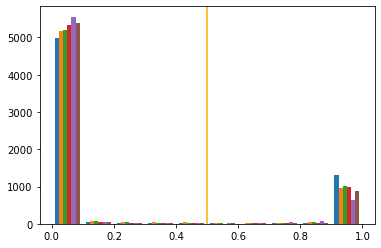

In [27]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [28]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [29]:
"{:0.2f}".format(pct_auc)

'99.75'

In [30]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [31]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [32]:
ydf.head(10)


,y_hat,y
0,1.085675e-03,"[0, 0, 0, 0, 0, 1]"
1,1.014361e-12,"[0, 0, 1, 0, 0, 0]"
2,1.571964e-03,"[0, 1, 0, 0, 0, 0]"
3,9.999239e-01,"[1, 0, 0, 0, 0, 0]"
4,1.908963e-03,"[0, 1, 0, 0, 0, 0]"
5,2.195980e-04,"[0, 0, 0, 0, 0, 1]"
6,6.065422e-06,"[0, 0, 0, 1, 0, 0]"
7,1.012328e-02,"[0, 1, 0, 0, 0, 0]"
8,9.998790e-01,"[1, 0, 0, 0, 0, 0]"
9,2.789147e-03,"[0, 1, 0, 0, 0, 0]"


In [33]:
# cf_matrix = confusion_matrix(y_valid, y_hat)
# print(cf_matrix) # doesn't work coz we have probability not class
y_hat

array([[1.08567462e-03, 9.79828087e-07, 5.76863272e-07, 1.10021665e-05,
        5.60071328e-07, 9.98901129e-01],
       [1.01436123e-12, 2.95527193e-13, 9.99883771e-01, 1.16090232e-04,
        1.42721125e-23, 1.00579825e-07],
       [1.57196401e-03, 9.45379317e-01, 5.27410172e-02, 2.98061903e-04,
        8.99877506e-08, 9.57882730e-06],
       ...,
       [7.32541608e-04, 7.65393605e-04, 3.37213773e-04, 3.06861009e-04,
        4.94983688e-05, 9.97808516e-01],
       [9.99810159e-01, 1.80489304e-10, 7.36931369e-08, 1.89810962e-04,
        4.84277028e-11, 2.50737663e-13],
       [9.99800384e-01, 1.42068940e-10, 7.26918969e-08, 1.99504881e-04,
        3.58024548e-11, 2.15082130e-13]], dtype=float32)

In [34]:
# convert probability to class
y_pred_class = np.argmax(y_hat, axis=1)
y_class = np.argmax(y_valid, axis = 1)

array([[1360,   19,    3,    2,   20,   23],
       [   0, 1023,   15,    1,   16,    9],
       [   2,   17, 1077,    8,    7,    3],
       [   2,    3,   29, 1038,    6,    9],
       [   0,   47,    1,    1,  752,    4],
       [  18,    6,    9,    2,    9,  935]], dtype=int64)

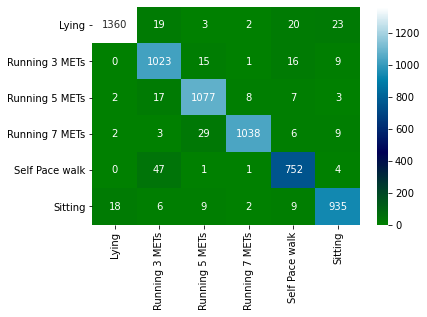

In [41]:
cf_matrix = confusion_matrix(y_class, y_pred_class, labels=range(6))
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt = '1', xticklabels=class_list, yticklabels=class_list, cmap='ocean')
cf_matrix